In [19]:
# Load reference dict:
import json
import os
import re
import tifffile as tf

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split('(\d+)', text) ]


In [3]:
import scipy.io as spio
import numpy as np

def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)

    return _check_keys(data)


def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], spio.matlab.mio5_params.mat_struct):
            dict[key] = _todict(dict[key])

    return dict


def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, spio.matlab.mio5_params.mat_struct):
            dict[strg] = _todict(elem)
        elif isinstance(elem,np.ndarray):
            dict[strg] = _tolist(elem)
        else:
            dict[strg] = elem

    return dict


def _tolist(ndarray):
    '''
    A recursive function which constructs lists from cellarrays 
    (which are loaded as numpy ndarrays), recursing into the elements
    if they contain matobjects.
    '''
    elem_list = []
    for sub_elem in ndarray:
        if isinstance(sub_elem, spio.matlab.mio5_params.mat_struct):
            elem_list.append(_todict(sub_elem))
        elif isinstance(sub_elem,np.ndarray):
            elem_list.append(_tolist(sub_elem))
        else:
            elem_list.append(sub_elem)

    return elem_list


In [4]:
source = '/nas/volume1/2photon/projects'
experiment = 'scenes'
session = '20171003_JW016'
acquisition = 'FOV1'
functional_dir = 'functional'

acquisition_dir = os.path.join(source, experiment, session, acquisition)

refdict_fn = 'reference_%s.json' % functional_dir
with open(os.path.join(acquisition_dir, refdict_fn), 'r') as fr:
    ref = json.load(fr)

ref.keys()

[u'ntiffs',
 u'slices',
 u'roiparams_path',
 u'trace_structs',
 u'functional',
 u'source_to_average',
 u'session',
 u'lines_per_frame',
 u'roi_id',
 u'simeta_path',
 u'acquisition_base_dir',
 u'data_dir',
 u'trace_dir',
 u'pixels_per_line',
 u'source',
 u'experiment',
 u'base_filename',
 u'signal_channel',
 u'raw_simeta_path',
 u'nchannels',
 u'corrected',
 u'mcparams_path',
 u'nvolumes',
 u'use_bidi_corrected',
 u'trace_id',
 u'roi_method',
 u'acquisition']

In [7]:
# Get ROI methods:

roi_methods_dir = os.path.join(acquisition_dir, 'ROIs')
roi_methods = os.listdir(roi_methods_dir)
roi_methods = [str(r) for r in roi_methods]
roi_methods_dict = dict()
print "Loading..."
for r in roi_methods:
    roiparams = loadmat(os.path.join(roi_methods_dir, r, 'roiparams.mat'))
    roiparams = roiparams['roiparams']
    roi_methods_dict[r] = dict()
    #roi_methods_dict[r]['maskpaths'] = roiparams['maskpaths']
    maskpaths = roiparams['maskpaths']
    if isinstance(maskpaths, unicode):
        roi_methods_dict[r]['Slice01'] = dict()
        masks = loadmat(maskpaths); masks = masks['masks']
        roi_methods_dict[r]['Slice01']['nrois'] = masks.shape[2]
        roi_methods_dict[r]['Slice01']['masks'] = masks       
    else:
        for si,sl in enumerate(maskpaths):
            masks = loadmat(sl); masks = masks['masks']
            roi_methods_dict[r]['Slice{:02d}'.format(si+1)] = dict()
            roi_methods_dict[r]['Slice{:02d}'.format(si+1)]['nrois'] = masks.shape[2]
            roi_methods_dict[r]['Slice{:02d}'.format(si+1)]['masks'] = masks
    

Loading...


In [8]:
# Get TRACE methods:
trace_methods_dir = os.path.join(acquisition_dir, 'Traces')
trace_methods = os.listdir(trace_methods_dir)
trace_methods = [str(r) for r in trace_methods]

print "Trace methods:"
trace_methods

Trace methods:


['blobs_DoG']

In [9]:
# Get SLICE list:
if isinstance(ref['slices'], int):
    slice_names = ['Slice01']
else:
    slice_names = ["Slice{:02d}".format(i+1) for i in range(len(ref['slices']))]

# print "Slices:"
# slice_names


In [10]:
# Get FILE list:
average_source = 'Averaged_Slices_Corrected'
signal_channel = 1

average_slice_dir = os.path.join(acquisition_dir, functional_dir, 'DATA', average_source, "Channel{:02d}".format(signal_channel))
file_fns = [f for f in os.listdir(average_slice_dir) if '_vis' not in f]
print file_fns
nfiles = len(file_fns)

curr_file = file_fns[0]
print curr_file


['File001', 'File002', 'File003', 'File004']
File001


In [11]:
# Get AVERAGE slices:

slice_fns = sorted([f for f in os.listdir(os.path.join(average_slice_dir, curr_file)) if f.endswith('.tif')], key=natural_keys)

print len(slice_fns)

41


In [12]:
current_roi_name = 'blobs_DoG'
roiparams_path = os.path.join(acquisition_dir, 'ROIs', current_roi_name, 'roiparams.mat')
roiparams = loadmat(roiparams_path)
roiparams = roiparams['roiparams']

maskpaths = roiparams['maskpaths']
print roiparams.keys()

['nrois', 'maskpaths', 'maskpath3d', 'params', 'roi_info', 'sourcepaths']


In [13]:
trace_types = ['raw', 'meansub', 'df/f']
tracestruct = loadmat(os.path.join(ref['trace_dir'], ref['trace_structs'][20]))
traces = tracestruct['file'][0]
print traces.df_f.T.shape

(158, 1900)


In [14]:
nfiles = len(tracestruct['file'])
nframes = traces.df_f.T.shape[1]
nrois = traces.df_f.T.shape[0]
print "N files:", nfiles
print "N frames:", nframes
print "N rois:", nrois

N files: 4
N frames: 1900
N rois: 158


## Look at traces from ROIs by slice/file:

In [230]:
current_roi_method = 'blobs_DoG'

file_idx = 1
slice_idx = 29 #24

In [231]:
import matplotlib.pyplot as plt

In [232]:
curr_file = file_fns[file_idx]
curr_slice_dir = os.path.join(average_slice_dir, curr_file)
slice_fns = os.listdir(curr_slice_dir)
slice_fns = sorted([s for s in slice_fns if s.endswith('.tif')], key=natural_keys)

curr_slice_name = slice_names[slice_idx]
print curr_slice_name
avg_img_fn = slice_fns[slice_idx]
print avg_img_fn

tracestruct = loadmat(os.path.join(ref['trace_dir'], ref['trace_structs'][slice_idx]))
print ref['trace_structs'][slice_idx]
if nfiles==1:
    traces = tracestruct['file']
else:
    traces = tracestruct['file'][file_idx]


Slice30
average_Slice30_Channel01_File002.tif
traces_Slice30_Channel01.mat


In [233]:
# curr_mask = roi_methods_dict[current_roi_method][curr_slice_name]['masks'][:,:,0] #max_idxs[0]]
# mask_img = np.copy(curr_mask)
# mask_img = np.ma.masked_where(curr_mask==0, curr_mask)

### Plot all ROIs by color on avg slice img:

In [234]:
def get_spaced_colors(n):
    max_value = 16581375 #255**3
    interval = int(max_value / n)
    colors = [hex(I)[2:].zfill(6) for I in range(1, max_value, interval)]

    return [(int(i[:2], 16), int(i[2:4], 16), int(i[4:], 16)) for i in colors]

In [235]:
tiffpath = os.path.join(curr_slice_dir, avg_img_fn)
with tf.TiffFile(tiffpath) as tif:
    img = tif.asarray()
    
plt.imshow(img, cmap='gray')
#plt.imshow(mask_img, color=colorvals[20]) #, alpha=0.5)
plt.show()

In [236]:
curr_slice_name

'Slice30'

In [246]:
curr_masks = roi_methods_dict[current_roi_method][curr_slice_name]['masks']
label_masks = np.zeros((curr_masks.shape[0], curr_masks.shape[1]))
print label_masks.shape
roi_idx = 1
for roi in range(nrois):
    label_masks[curr_masks[:,:,roi]==1] = int(roi_idx)
    roi_idx += 1

(100, 120)


In [251]:
allmasks = np.sum(curr_masks, axis=2)
allmasks.shape


# plt.figure()
# plt.imshow(allmasks)

(100, 120)

In [249]:
label_masks[label_masks>0]
print img.shape

(100, 120)


<IPython.core.display.Javascript object>


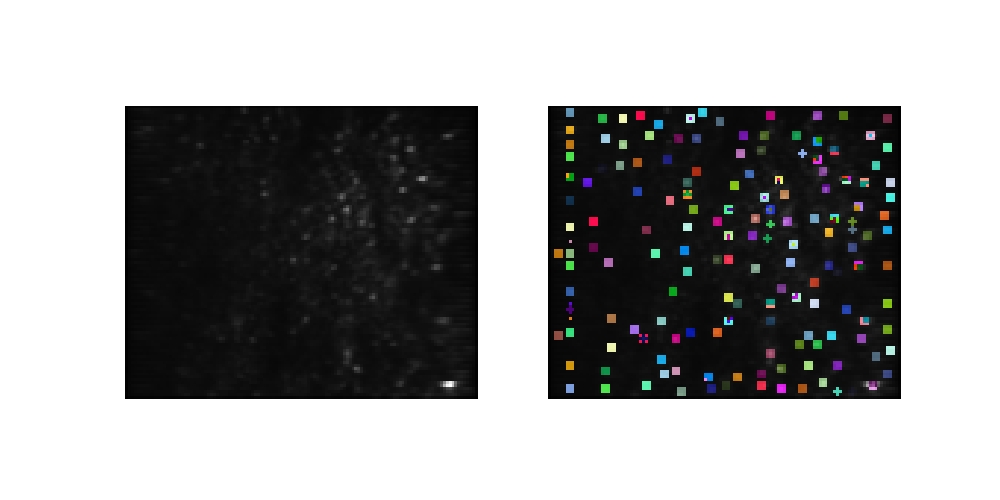

645
1.0


In [250]:
import skimage.color
plt.figure(figsize=(10,5))
# plt.imshow(img)
print img.max()
imgnorm = np.true_divide((img - img.min()), (img.max()-img.min()))
print imgnorm.max()
plt.subplot(121)
plt.imshow(imgnorm, cmap='gray'); #plt.colorbar()
plt.axis('off')
plt.subplot(122)
plt.imshow(skimage.color.label2rgb(label_masks, image=imgnorm, alpha=0.05, colors=colorvals, bg_label=0))
plt.axis('off')
plt.show()

# PLOTTING

In [30]:
from bokeh.plotting import figure
import tifffile as tf
import seaborn as sns
import matplotlib.pylab as plt

%matplotlib notebook

from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt

import os
figdir = os.path.join(acquisition_dir, 'example_figures')

figdir


'/nas/volume1/2photon/projects/scenes/20171003_JW016/FOV1/example_figures'

### Split all frames from all files by trial / stimulus:

In [31]:
class StimInfo:
    def _init_(self):
        self.stimid = ''
        self.trials = []
        self.frames = []
        self.frames_sec = []
        self.stim_on_idx = []


In [33]:
path_to_functional = os.path.join(acquisition_dir, functional_dir)
paradigm_dir = 'paradigm_files'
path_to_paradigm_files = os.path.join(path_to_functional, paradigm_dir)

stiminfo_basename = 'stiminfo'

# Load reference info:
ref_json = 'reference_%s.json' % functional_dir
with open(os.path.join(acquisition_dir, ref_json), 'r') as fr:
    ref = json.load(fr)

# Load SI meta data:
si_basepath = ref['raw_simeta_path'][0:-4]
simeta_json_path = '%s.json' % si_basepath
with open(simeta_json_path, 'r') as fs:
    simeta = json.load(fs)

nframes = int(simeta['File001']['SI']['hFastZ']['numVolumes'])
framerate = float(simeta['File001']['SI']['hRoiManager']['scanFrameRate'])
volumerate = float(simeta['File001']['SI']['hRoiManager']['scanVolumeRate'])
frames_tsecs = np.arange(0, nframes)*(1/volumerate)


# frame info:
first_frame_on = 50
stim_on_sec = 0.5
iti = 1.
vols_per_trial = 15

nframes_on = stim_on_sec * volumerate
nframes_off = vols_per_trial - nframes_on
frames_iti = round(iti * volumerate)

# Create stimulus-dict:
stimdict = dict()
for fi in range(nfiles):
    currfile = "File%03d" % int(fi+1)
    stim_fn = 'stim_order.txt'

    # Load stim-order:
    with open(os.path.join(path_to_paradigm_files, stim_fn)) as f:
        stimorder = f.readlines()
    curr_stimorder = [l.strip() for l in stimorder]
    unique_stims = sorted(set(curr_stimorder), key=natural_keys)
    first_frame_on = 50
    for trialnum,stim in enumerate(curr_stimorder):
        #print "Stim on frame:", first_frame_on
        if not stim in stimdict.keys():
            stimdict[stim] = dict()
        if not currfile in stimdict[stim].keys():
            stimdict[stim][currfile] = StimInfo()
            stimdict[stim][currfile].trials = []
            stimdict[stim][currfile].frames = []
            stimdict[stim][currfile].frames_sec = []
            stimdict[stim][currfile].stim_on_idx = []

        framenums = list(np.arange(int(first_frame_on-frames_iti), int(first_frame_on+(vols_per_trial))))
        frametimes = [frames_tsecs[f] for f in framenums]
        stimdict[stim][currfile].trials.append(trialnum)      
        stimdict[stim][currfile].frames.append(framenums)
        stimdict[stim][currfile].frames_sec.append(frametimes)
        stimdict[stim][currfile].stim_on_idx.append(framenums.index(first_frame_on))
        first_frame_on = first_frame_on + vols_per_trial


In [34]:
stimdict[stim][currfile].stim_on_idx
#[stimdict[stim][currfile].stim_on_idx, float(stimdict[stim][currfile].stim_on_idx) + stim_on_sec*volumerate]

[5, 5]

### Split traces by stimulus ID:

In [35]:

stim_ntrials = dict()
for stim in stimdict.keys():
    stim_ntrials[stim] = 0
    for fi in stimdict[stim].keys():
        stim_ntrials[stim] += len(stimdict[stim][fi].trials)

# To look at all traces for ROI 3 for stimulus 1:
# traces_by_stim['1'][:,roi,:]

traces_by_stim = dict()
frames_stim_on = dict()
for stim in stimdict.keys():
    repidx = 0
    curr_traces_allrois = []
    stim_on_frames = []
    for fi,currfile in enumerate(sorted(file_fns, key=natural_keys)):
        frames_by_trial = stimdict[stim][currfile].frames
        for currtrial in range(len(frames_by_trial)):
            currframes = stimdict[stim][currfile].frames[currtrial]

            curr_traces_allrois.append(tracestruct['file'][fi].tracematDC.T[:, currframes])
            repidx += 1
            
            curr_frame_onset = stimdict[stim][currfile].stim_on_idx[currtrial]
            
            stim_on_frames.append([curr_frame_onset, curr_frame_onset + stim_on_sec*volumerate])

    traces_by_stim[stim] = np.asarray(curr_traces_allrois)
    frames_stim_on[stim] = stim_on_frames

In [36]:
frames_stim_on['1']

[[5, 7.295999999999999],
 [5, 7.295999999999999],
 [5, 7.295999999999999],
 [5, 7.295999999999999],
 [5, 7.295999999999999],
 [5, 7.295999999999999],
 [5, 7.295999999999999],
 [5, 7.295999999999999]]

In [37]:
nstimuli = len(stimdict.keys())

colorvals = np.tile(['r', 'b', 'm', 'g', 'c'], (1, nstimuli/5))
colorvals[0]

array(['r', 'b', 'm', 'g', 'c', 'r', 'b', 'm', 'g', 'c', 'r', 'b', 'm',
       'g', 'c', 'r', 'b', 'm', 'g', 'c', 'r', 'b', 'm', 'g', 'c', 'r',
       'b', 'm', 'g', 'c', 'r', 'b', 'm', 'g', 'c', 'r', 'b', 'm', 'g',
       'c', 'r', 'b', 'm', 'g', 'c', 'r', 'b', 'm', 'g', 'c', 'r', 'b',
       'm', 'g', 'c', 'r', 'b', 'm', 'g', 'c'], 
      dtype='|S1')

<IPython.core.display.Javascript object>


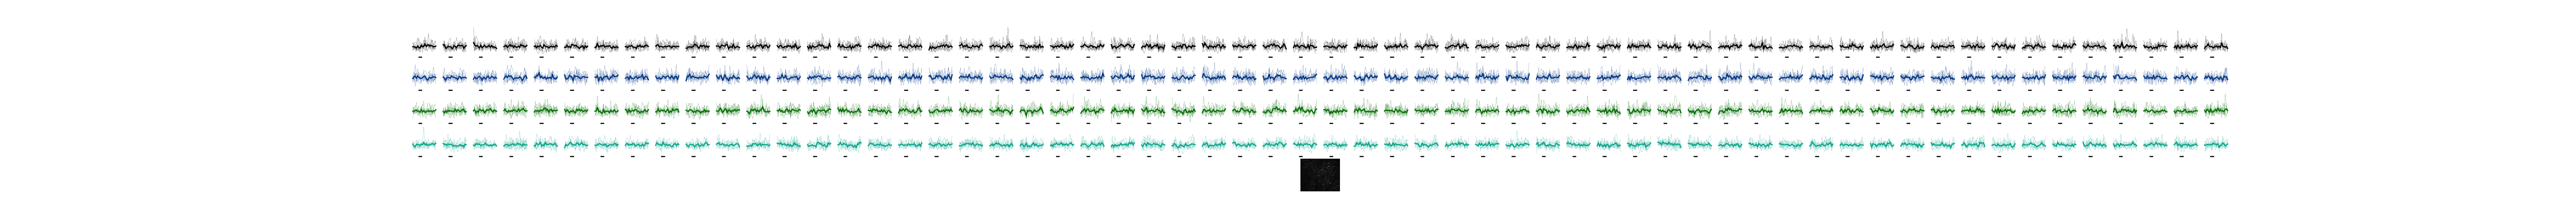

In [130]:
color_by_roi = True

plot_rois = 5 #int(nrois/2)
nstimuli = len(stimdict.keys())

spacing = 25

# if color_by_roi:
#     colorvals = get_spaced_colors(nstimuli)
# else:
#     coorvals = get_spaced_colors(nrois)
# colorvals = np.true_divide(colorvals, 255.)
             
fig = plt.figure(figsize=(60,5))
gs = gridspec.GridSpec(plot_rois, 1) #, height_ratios=[1,1,1,1]) 
gs.update(wspace=0.01, hspace=0.01)
for roi in range(plot_rois): # nrois
    #rowindex = roi + roi*nstimuli
    plt.subplot(gs[roi])
    plt.axis('off')
    #ax = plt.gca()
        
    for stimnum,stim in enumerate(traces_by_stim.keys()):
        #plt.subplot(gs[roi, stimnum])
        #print stim
        raw = traces_by_stim[stim][:, roi, :]
        #avg = np.mean(raw, axis=0)
        xvals = np.arange(0, raw.shape[1]) + stimnum*spacing
        #xvals = np.tile(np.arange(0, raw.shape[1]), (raw.shape[0], 1))
        dfs = np.empty((raw.shape[0], raw.shape[1]))
        for trial in range(raw.shape[0]):
            frame_on = frames_stim_on[stim][trial][0]
            baseline = np.mean(raw[trial,0:frame_on])
            df = (raw[trial,:] - baseline / baseline)
            dfs[trial,:] = df
            if color_by_roi:
                plt.plot(xvals, df, color=colorvals[roi], alpha=1, linewidth=0.2)
            else:
                plt.plot(xvals, df, color=colorvals[stimnum], alpha=1, linewidth=0.2)
            
            stim_frames = xvals[0]+frames_stim_on[stim][trial]
            
            plt.plot(stim_frames, np.ones((2,))*-20, color='k')
        
        avg = np.mean(dfs, axis=0)
        if color_by_roi:
            plt.plot(xvals, avg, color=colorvals[roi], alpha=1, linewidth=2)
        else:
            plt.plot(xvals, avg, color=colorvals[stimnum], alpha=1, linewidth=2)
    
    if roi<plot_rois-1:
        #sns.despine(bottom=True)
        plt.axis('off')
        plt.ylabel(str(roi))
    else:
        #ax.axes.get_xaxis().set_visible(False)
        #ax.axes.get_xaxis().set_ticks([])
        plt.yticks([0, 100])

#fig.tight_layout()
sns.despine(offset=1, trim=True)

figdir = os.path.join(acquisition_dir, 'example_figures')
figname = 'traces_by_stimulus_all_rois.png'
#plt.savefig(os.path.join(figdir, figname), bbox_inches='tight')
plt.show()


In [28]:
import os
figdir = os.path.join(acquisition_dir, 'example_figures')

figdir

'/nas/volume1/2photon/projects/scenes/20171003_JW016/FOV1/example_figures'

In [304]:
stim_frames = xvals[0]+frames_stim_on[stim][trial]
stim_frames

array([  9.   ,  11.296])

In [274]:
xvals.shape
raw.shape

(8, 24)

<IPython.core.display.Javascript object>


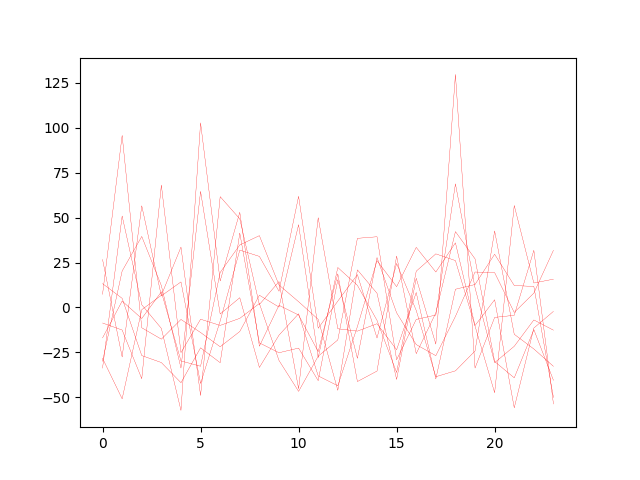

In [278]:
plt.figure()
for trial in range(xvals.shape[0]):
    plt.plot(xvals[trial,:], raw[trial,:], color=colorvals[roi], alpha=1, linewidth=0.2)

In [269]:
xvals + trial*spacing

array([[ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
        24, 25, 26, 27, 28, 29, 30],
       [ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
        24, 25, 26, 27, 28, 29, 30],
       [ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
        24, 25, 26, 27, 28, 29, 30],
       [ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
        24, 25, 26, 27, 28, 29, 30],
       [ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
        24, 25, 26, 27, 28, 29, 30],
       [ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
        24, 25, 26, 27, 28, 29, 30],
       [ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
        24, 25, 26, 27, 28, 29, 30],
       [ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
        24, 25, 26, 27, 28, 29, 30]])

In [261]:
xs = xvals*np.tile(np.arange(0, xvals.shape[0]*10, 10), (xvals.shape[1], 1)).T
xs.shape

(8, 24)

In [137]:
# plt.figure(figsize=(10,5))
# sns.tsplot(data=trace_array, ci="sd", linewidth=.5, alpha=1)
# sns.despine(offset=5)
# plt.show()


#### Look at each file as a "heatmap" of traces (sorted):

<IPython.core.display.Javascript object>


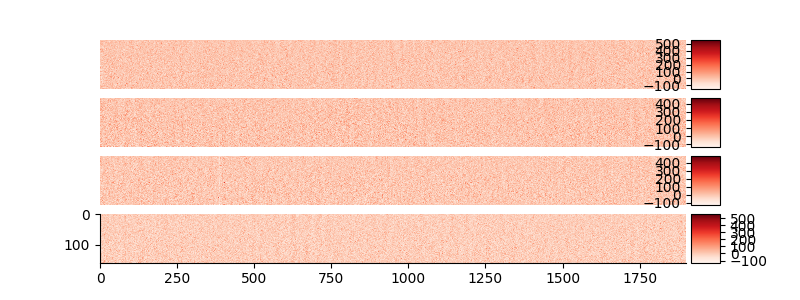

In [227]:
fig = plt.figure(figsize=(8,3))
gs = gridspec.GridSpec(4, 1) #, height_ratios=[1,1,1,1]) 
gs.update(wspace=0.01, hspace=0.01)

colorvals = ['r', 'b', 'm', 'g', 'c', 'r', 'b', 'm', 'g', 'c', 'r', 'b', 'm', 'g', 'c']


nfiles = len(tracestruct['file'])
for fi in range(nfiles):
    currtraces = tracestruct['file'][fi].df_f.T
    plt.subplot(gs[fi])
    
    ax = plt.gca()
    im = ax.imshow(currtraces[max_idxs,:], cmap=plt.cm.Reds)
    
    if fi<nfiles-1:
        ax.axis('off')
    else:
        sns.despine()
    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    plt.colorbar(im, cax=cax)



### Sort ROIs by max-DF:

In [196]:
# reftraces = tracestruct['file'][1].df_f.T
# max_vals = np.amax(reftraces, axis=1)
# max_idxs = sorted(range(len(max_vals)), key=lambda k: max_vals[k])

maxavgs = []
for roi in range(nrois):
    trace_array = np.empty((nfiles,nframes))
    for fi in range(nfiles):
        trace_array[fi,:] = tracestruct['file'][fi].df_f.T[max_idxs[roi],:]
    #stdevs.append(np.mean(np.std(trace_array, axis=0)))
    maxavgs.append(np.max(np.mean(trace_array, axis=0)))

maxavg_idxs = sorted(range(len(maxavgs)), key=lambda k: maxavgs[k], reverse=True)
print [maxavgs[i] for i in maxavg_idxs[0:5]]

[192.98329462661468, 88.726606518257157, 88.175252843700264, 86.236974308716412, 86.008767413081316]


<IPython.core.display.Javascript object>


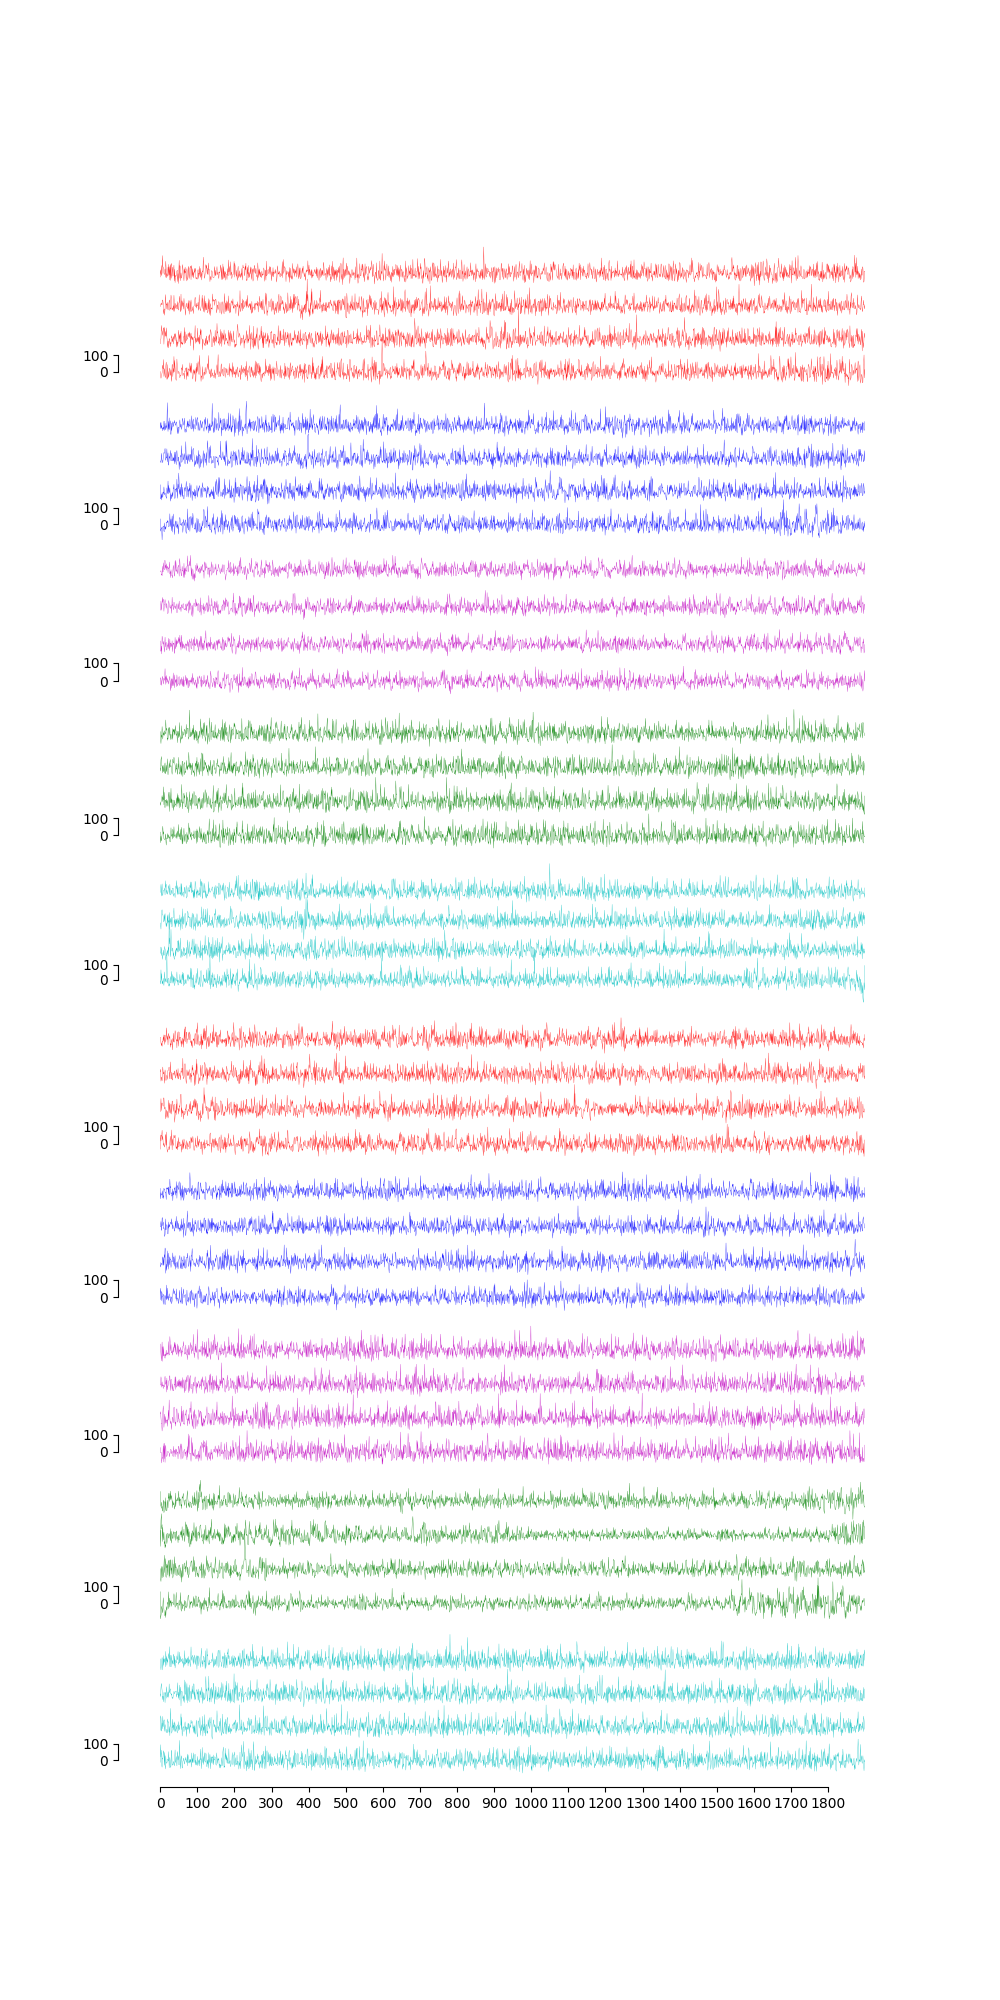

In [198]:
fig = plt.figure(figsize=(10,20))

nrois_to_show = 10
colorvals = ['r', 'b', 'm', 'g', 'c', 'r', 'b', 'm', 'g', 'c', 'r', 'b', 'm', 'g', 'c']

gs = gridspec.GridSpec(nrois_to_show, 1) #, height_ratios=[1,1,1,1]) 
gs.update(wspace=0.01, hspace=0.01)

for roi in range(nrois_to_show):
    plt.subplot(gs[roi])
    if roi<nrois_to_show-1:
        sns.despine(bottom=True)
    for fi in range(nfiles):
        currtraces = tracestruct['file'][fi].df_f.T
        nframes = currtraces.shape[1]
    
        plt.plot(np.arange(0, nframes), currtraces[maxavg_idxs[roi],:]+(fi*200), color=colorvals[roi], alpha=1, linewidth=0.2)
        plt.yticks([0, 100])
        plt.xticks(np.arange(0, nframes, 100))

sns.despine(offset=5, trim=True)

#### Sort ROIs from 1 file (reference) using max-DF / std:

In [193]:
maxes = []
stdevs = []
for roi in range(nrois):
    trace_array = np.empty((nfiles,nframes))
    for fi in range(nfiles):
        trace_array[fi,:] = tracestruct['file'][fi].df_f.T[max_idxs[roi],:]
    stdevs.append(np.mean(np.std(trace_array, axis=0)))
    maxes.append(np.max(np.mean(trace_array, axis=0)))

# sorted_idxs = sorted(range(len(stdevs)), key=lambda k: stdevs[k])
# print sorted_idxs[0:5]
# print [stdevs[i] for i in sorted_idxs[0:5]]
ratiomax = np.true_divide(maxes, stdevs)
print ratiomax.shape
sorted_idxs = sorted(range(len(ratiomax)), key=lambda k: ratiomax[k], reverse=True)
print [ratiomax[i] for i in sorted_idxs[0:5]]

(158,)
[4.3414105861996681, 3.426513641779616, 3.3692705874381601, 3.3605534404745447, 3.2853426665215837]


#### Traces grouped by file for ROIs with smallest STD:

<IPython.core.display.Javascript object>


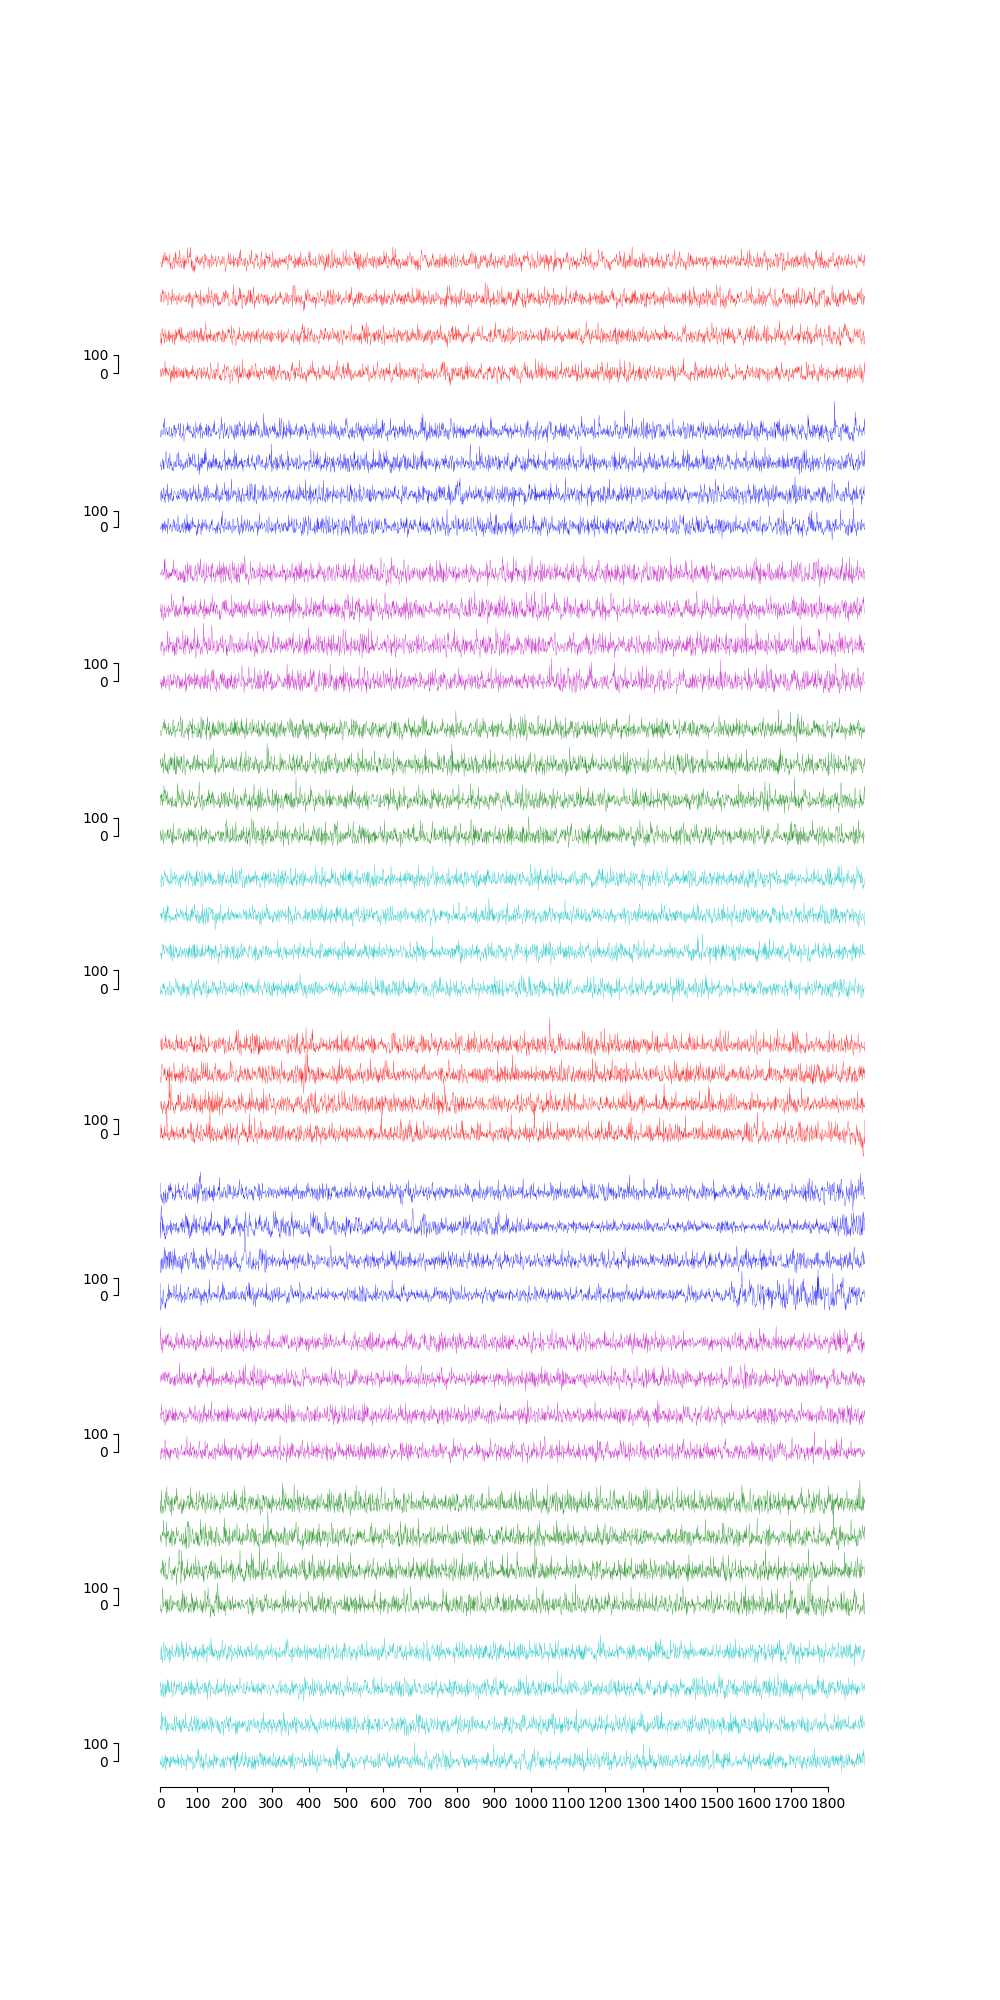

In [194]:
fig = plt.figure(figsize=(10,20))


nrois_to_show = 10
colorvals = ['r', 'b', 'm', 'g', 'c', 'r', 'b', 'm', 'g', 'c', 'r', 'b', 'm', 'g', 'c']
alphavals = np.arange(0.3, 1, (1-0.3)/nrois_to_show)
#print alphavals

gs = gridspec.GridSpec(nrois_to_show, 1) #, height_ratios=[1,1,1,1]) 
gs.update(wspace=0.01, hspace=0.01)

for roi in range(nrois_to_show):
    trace_array = np.empty((nfiles,nframes))
    for fi in range(nfiles):
        trace_array[fi,:] = tracestruct['file'][fi].df_f.T[max_idxs[roi],:]
    avg_trace = np.mean(trace_array, axis=0)

    plt.subplot(gs[roi])
    if roi<nrois_to_show-1:
        sns.despine(bottom=True)
    for fi in range(nfiles):
        currtraces = tracestruct['file'][fi].df_f.T
        nframes = currtraces.shape[1]
    
        plt.plot(np.arange(0, nframes), currtraces[sorted_idxs[roi],:]+(fi*200), color=colorvals[roi], alpha=1, linewidth=0.2)
        plt.yticks([0, 100])
        plt.xticks(np.arange(0, nframes, 100))
        #plt.plot(np.arange(0, nframes), avg_trace, color=colorvals[roi], alpha=0.75, linewidth=0.5)

sns.despine(offset=5, trim=True)

#### Traces grouped by file, ROIs sorted by max DF/F:

<IPython.core.display.Javascript object>


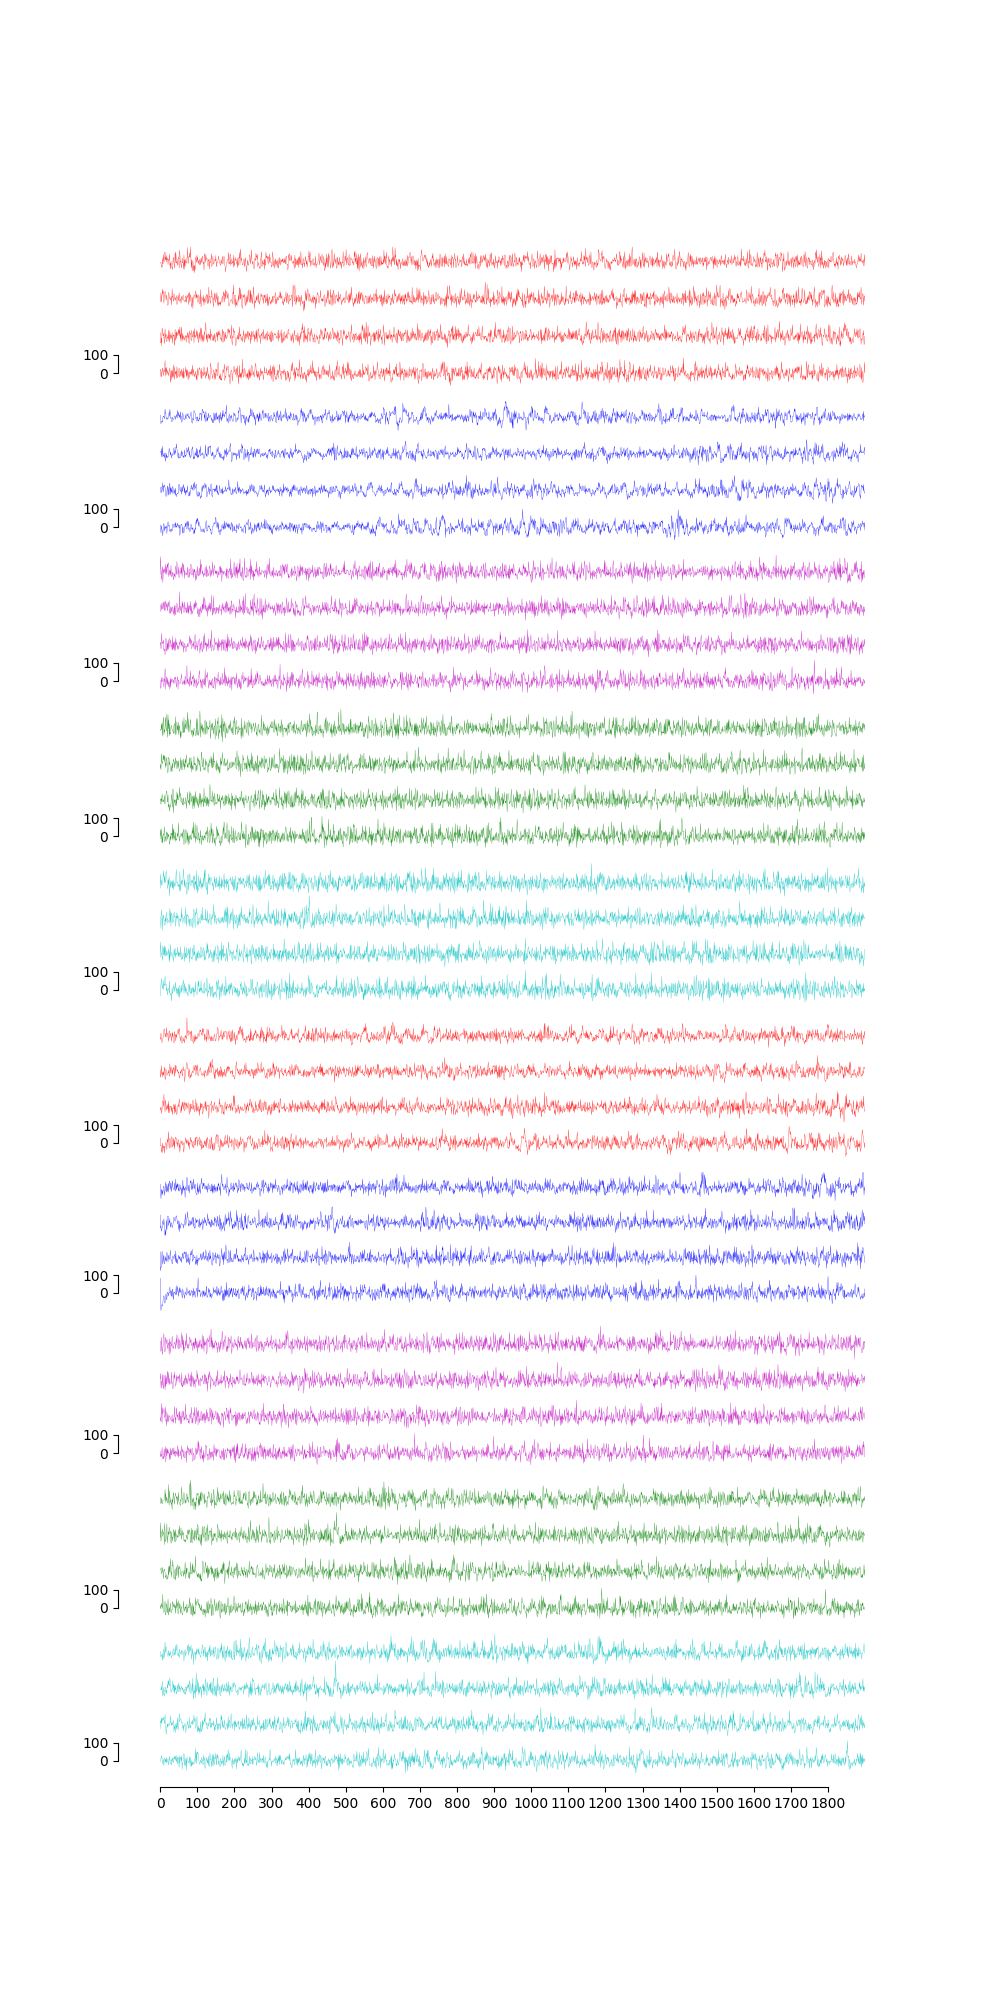

In [154]:
fig = plt.figure(figsize=(10,20))

nrois_to_show = 10
colorvals = ['r', 'b', 'm', 'g', 'c', 'r', 'b', 'm', 'g', 'c', 'r', 'b', 'm', 'g', 'c']
#colorvals = [np.random.rand(3,1) for r in range(nrois_to_show)]
alphavals = np.arange(0.3, 1, (1-0.3)/nrois_to_show)
#print alphavals

gs = gridspec.GridSpec(nrois_to_show, 1) #, height_ratios=[1,1,1,1]) 
gs.update(wspace=0.01, hspace=0.01)

for roi in range(nrois_to_show):
    trace_array = np.empty((nfiles,nframes))
    for fi in range(nfiles):
        trace_array[fi,:] = tracestruct['file'][fi].df_f.T[max_idxs[roi],:]
    avg_trace = np.mean(trace_array, axis=0)

    plt.subplot(gs[roi])
    if roi<nrois_to_show-1:
        sns.despine(bottom=True)
    for fi in range(nfiles):
        currtraces = tracestruct['file'][fi].df_f.T
        nframes = currtraces.shape[1]
    
        plt.plot(np.arange(0, nframes), currtraces[max_idxs[roi],:]+(fi*200), color=colorvals[roi], alpha=1, linewidth=0.2)
        plt.yticks([0, 100])
        plt.xticks(np.arange(0, nframes, 100))
        #plt.plot(np.arange(0, nframes), avg_trace, color=colorvals[roi], alpha=0.75, linewidth=0.5)

sns.despine(offset=5, trim=True)

### Plot as heatmap:

<IPython.core.display.Javascript object>


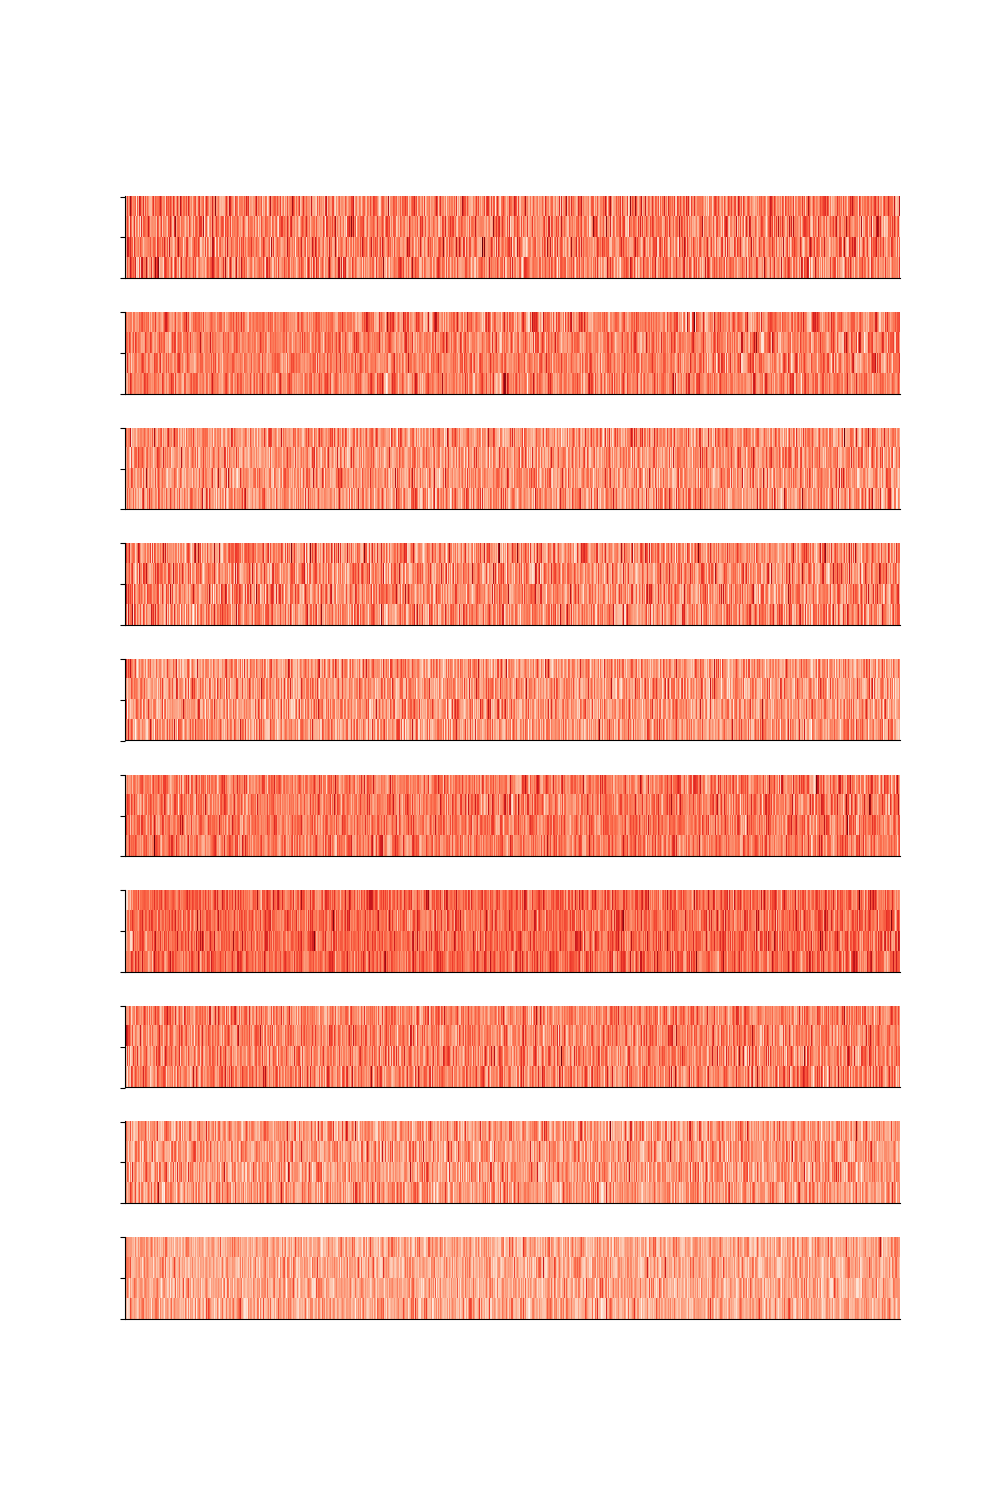

In [201]:
fig = plt.figure(figsize=(10,15))

nrois_to_show = 10

spacing = 50

#colorvals = ['r', 'b', 'm', 'g', 'c', 'r', 'b', 'm', 'g', 'c', 'r', 'b', 'm', 'g', 'c']
#colorvals = [np.random.rand(3,1) for r in range(nrois_to_show)]
#alphavals = np.arange(0.3, 1, (1-0.3)/nrois_to_show)
#print alphavals

gs = gridspec.GridSpec(nrois_to_show, 1) #, height_ratios=[1,1,1,1]) 
gs.update(wspace=0.01, hspace=0.01)

for roi in range(nrois_to_show):
    trace_array = np.empty((nfiles,nframes))
    tracemap = np.empty((nfiles*spacing, nframes))
    ax = plt.subplot(gs[roi])
    for fi in range(nfiles):
        trace_array[fi,:] = tracestruct['file'][fi].df_f.T[max_idxs[roi],:]
    #avg_trace = np.mean(trace_array, axis=0)
            
        tracemap[fi*spacing:(fi*spacing + spacing)] = trace_array[fi,:]
        plt.imshow(tracemap, cmap='Reds')
        ax.set_yticklabels('')
        if roi<nrois-1:
            ax.get_xaxis().set_visible(False)
        else:
            ax.get_xaxis().set_visible(True)

sns.despine()


<IPython.core.display.Javascript object>


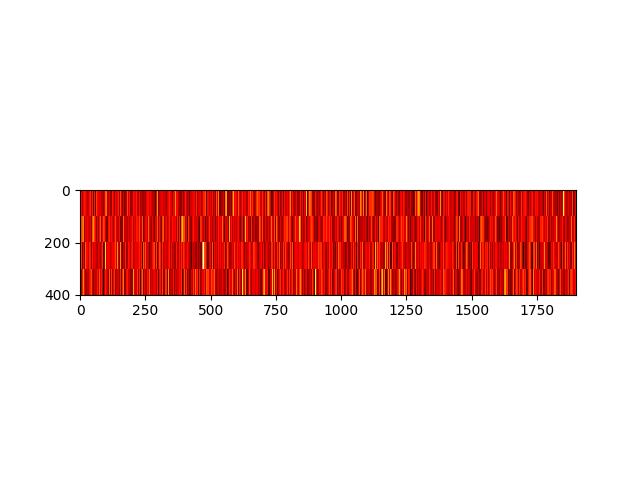

0 100
100 200
200 300
300 400


In [165]:
plt.figure()
spacing = 100
tracemap = np.empty((nfiles*spacing, nframes))
for fi in range(nfiles):
    print fi*spacing, (fi*spacing + spacing)
    tracemap[fi*spacing:(fi*spacing + spacing)] = trace_array[fi,:]
plt.imshow(tracemap, cmap='hot')


#### Look at average slice image with ROIs on top:

(158, 1900)
(158, 1900)
(158, 1900)
(158, 1900)


<IPython.core.display.Javascript object>


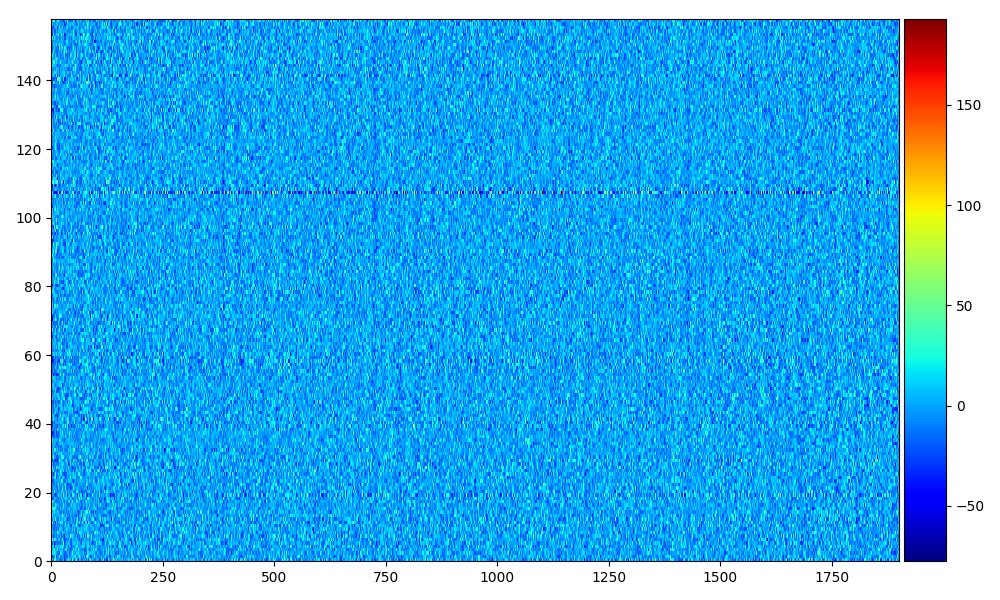

In [158]:
nfiles = len(tracestruct['file'])
sum_traces = 0
for fi in range(nfiles):
    currtraces = tracestruct['file'][fi]

    sum_traces += currtraces.df_f.T 
    print currtraces.df_f.T.shape
    
plt.figure(figsize=(10,6))
ax = plt.gca()

im = plt.pcolor(sum_traces/nfiles,cmap=plt.cm.Reds)
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.05)

plt.colorbar(im, cax=cax)
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


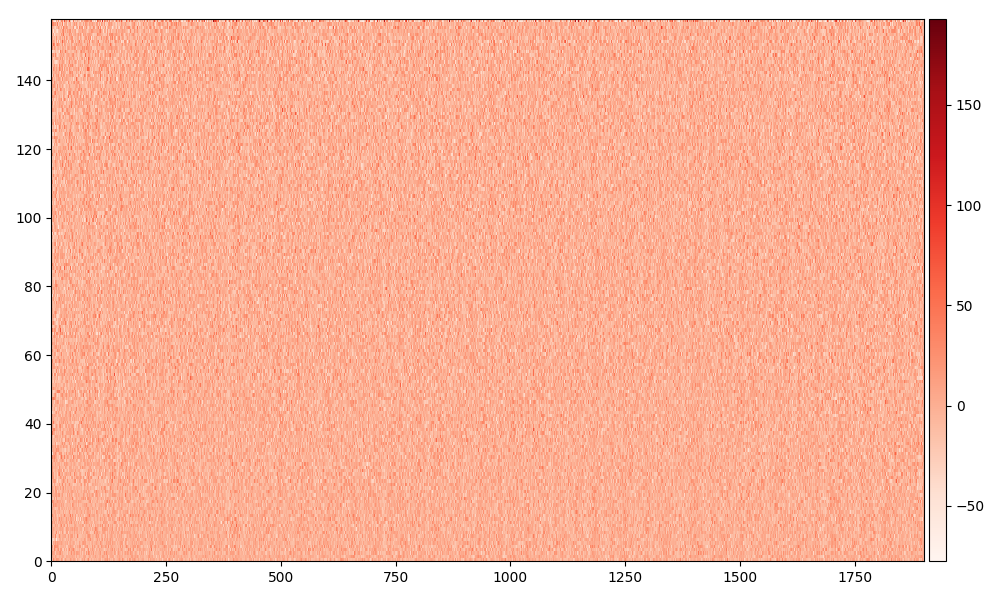

In [167]:
nfiles = len(tracestruct['file'])
sum_traces_sortmax = 0

reftraces = tracestruct['file'][1].df_f.T
max_vals = np.amax(reftraces, axis=1)
max_idxs = sorted(range(len(max_vals)), key=lambda k: max_vals[k])
#max_idxs
#max_sorted = currtraces[max_idxs,:]
    
    
for fi in range(nfiles):
    currtraces = tracestruct['file'][fi].df_f.T
    max_sorted = currtraces[max_idxs,:]
    sum_traces_sortmax += max_sorted
    
plt.figure(figsize=(10,6))
ax = plt.gca()

im = plt.pcolor(sum_traces_sortmax/nfiles,cmap=plt.cm.Reds)
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.05)

plt.colorbar(im, cax=cax)
plt.tight_layout()
plt.show()

In [164]:
currtraces = tracestruct['file'][fi].df_f.T
max_vals = np.amax(currtraces, axis=1)
max_idxs = sorted(range(len(max_vals)), key=lambda k: max_vals[k])
max_idxs

[3,
 92,
 63,
 33,
 134,
 103,
 115,
 52,
 75,
 136,
 34,
 122,
 114,
 104,
 105,
 85,
 118,
 83,
 37,
 137,
 150,
 31,
 87,
 130,
 18,
 132,
 96,
 112,
 74,
 123,
 99,
 81,
 124,
 143,
 77,
 129,
 9,
 76,
 71,
 140,
 100,
 139,
 48,
 16,
 142,
 89,
 51,
 45,
 113,
 117,
 42,
 61,
 116,
 154,
 128,
 8,
 101,
 72,
 23,
 106,
 109,
 38,
 1,
 14,
 127,
 149,
 55,
 53,
 138,
 15,
 69,
 62,
 68,
 102,
 121,
 90,
 44,
 131,
 98,
 65,
 135,
 151,
 120,
 21,
 5,
 46,
 60,
 84,
 88,
 6,
 2,
 111,
 25,
 73,
 80,
 133,
 30,
 11,
 4,
 13,
 40,
 64,
 10,
 29,
 86,
 152,
 66,
 94,
 43,
 24,
 146,
 70,
 22,
 119,
 28,
 79,
 26,
 108,
 110,
 82,
 49,
 91,
 156,
 155,
 59,
 153,
 54,
 36,
 47,
 20,
 35,
 32,
 57,
 147,
 41,
 17,
 39,
 125,
 7,
 12,
 0,
 93,
 78,
 141,
 67,
 27,
 50,
 95,
 126,
 56,
 145,
 144,
 97,
 157,
 58,
 148,
 19,
 107]

In [32]:
file_idx = 0
slice_idx = 20

In [42]:
curr_file = file_fns[file_idx]
curr_slice_dir = os.path.join(average_slice_dir, curr_file)
slice_fns = os.listdir(curr_slice_dir)
slice_fns = sorted([s for s in slice_fns if s.endswith('.tif')], key=natural_keys)

curr_slice = slice_names[slice_idx]

avg_img_fn = slice_fns[slice_idx]

tiffpath = os.path.join(curr_slice_dir, avg_img_fn)
with tf.TiffFile(tiffpath) as tif:
    img = tif.asarray()
    
# tracestruct = loadmat(os.path.join(acquisition_dir, 'Traces', ref['trace_structs'][slice_idx]))
# if nfiles==1:
#     traces = tracestruct['file']
# else:
#     traces = tracestruct['file'][curr_file_idx]
    

KeyError: 'trace_structs'

<IPython.core.display.Javascript object>


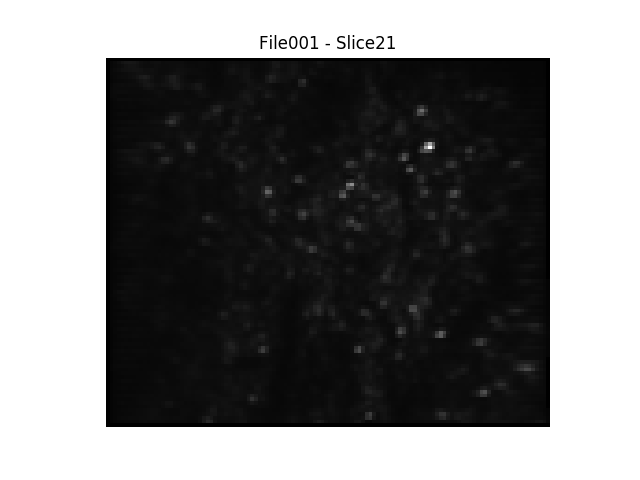

(-0.5, 119.5, 99.5, -0.5)